# **Model Evaluation**

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import sys
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from transformers import BertTokenizer, BertModel
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics.pairwise import cosine_similarity


from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
torch.manual_seed(42)
random.seed(42)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Now, that we've prepared the necessary imports and devices again, it's time to load the data with the same splits as before:

In [4]:
metadata = pd.read_csv("/content/drive/MyDrive/Image captioning/captions.txt", sep="|")
metadata_test = metadata.iloc[:4045]
metadata_val = metadata.iloc[4045:8090]
metadata_train = metadata.iloc[8090:]

This time, the dataset is made a little bit differently, so that it does not return a random caption for the image, but all of the captions in a list instead.

In [5]:
class ImageDataset(Dataset):
    def __init__(self, metadata):
        super().__init__()
        self.images = []
        self.metadata = metadata

        for image_name in tqdm(metadata["image_name"].unique()):
            img = Image.open(os.path.join("/content/drive/MyDrive/Image captioning/archive/images", image_name))
            transform = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
            img_tensor = transform(img)

            self.images.append(img_tensor)

        print(len(self.images))
        self.images = torch.stack(self.images)
        print(self.images.size())

    def __len__(self):
        return self.images.size()[0]

    def __getitem__(self, idx):
        return (self.images[idx], self.metadata.iloc[idx*5 : idx*5+5]["caption_text"].to_list())

It's time to load the datasets again:

In [6]:
dataset_test = torch.load("/content/drive/MyDrive/Image captioning/saved_data/dataset_test.pt", weights_only=False)
# dataset_val = torch.load("/content/drive/MyDrive/Image captioning/saved_data/dataset_val.pt", weights_only=False)
dataset_train = torch.load("/content/drive/MyDrive/Image captioning/saved_data/dataset_train.pt", weights_only=False)

In order for the metric functions below to work properly, the batch sizes for the dataloaders have to be 1.

In [7]:
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=False)
# dataloader_val = DataLoader(dataset_val, batch_size=1, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)

We have to define the models again.

In [8]:
class ImageEncoder(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        self.efficient_net = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
        self.efficient_net.classifier = nn.Identity()
        self.fc1 = nn.Linear(1280, embed_size)

    def forward(self, images):
        features = self.efficient_net(images)
        embeds = self.fc1(features)
        return embeds

In [9]:
class TextEncoder(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.fc1 = nn.Linear(768, embed_size)

    def forward(self, captions):
        tokens = self.tokenizer(captions, padding=True, truncation=True, return_tensors="pt")
        input_ids = tokens["input_ids"].to(device)
        attention_mask = tokens["attention_mask"].to(device)

        outputs = self.bert(input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state
        embeds = self.fc1(last_hidden_state[:, 0, :])
        return embeds

In [10]:
image_encoder = ImageEncoder(embed_size=256).to(device)
text_encoder = TextEncoder(embed_size=256).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 88.7MB/s]
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Now it's time to load the encoders from epoch 50, because their performance was the best:

In [11]:
image_encoder.load_state_dict(torch.load("/content/drive/MyDrive/Image captioning/saved_data/image_encoder_epoch_50.pt"))
text_encoder.load_state_dict(torch.load("/content/drive/MyDrive/Image captioning/saved_data/text_encoder_epoch_50.pt"))

<ipython-input-11-43566bd6adca>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_encoder.load_state_dict(torch.load("/content/drive/MyDrive/Image captioning/saved_data

<All keys matched successfully>

In [12]:
image_encoder.eval()
text_encoder.eval()

TextEncoder(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

Now it's time to extract the embeddings for the images and the captions.

In [13]:
image_encodings_train = []
image_encodings_test = []

text_encodings_train = []
text_encodings_test = []

In [14]:
def extract_embeds(dataloader, image_encodings_list, text_encodings_list):
  for images, captions in tqdm(dataloader):
      images = images.to(device)

      image_embeds = image_encoder(images)
      for i in range(len(captions[0])):
          caption_group = [captions[j][i] for j in range(5)]
          text_embeds = text_encoder(caption_group)
          text_encodings_list.append(text_embeds.cpu().detach())
          image_encodings_list.append(image_embeds.cpu().detach())

In [15]:
extract_embeds(dataloader_train, image_encodings_train, text_encodings_train)

100%|██████████| 6473/6473 [03:00<00:00, 35.87it/s]


In [16]:
extract_embeds(dataloader_test, image_encodings_test, text_encodings_test)

100%|██████████| 809/809 [00:22<00:00, 35.59it/s]


Now that we have all of the embeddings, it's time to get the cosine similarities between the embeddigs.

In [17]:
def compute_similarity(image_encodings, text_encodings):
    image_encodings = torch.stack(image_encodings, dim=0).cpu().numpy().squeeze()
    text_encodings = torch.cat(text_encodings, dim=0).cpu().numpy()

    similarities = cosine_similarity(image_encodings, text_encodings)

    return similarities

In [18]:
similarities_test = compute_similarity(image_encodings_test, text_encodings_test)
similarities_train = compute_similarity(image_encodings_train, text_encodings_train)

The first metric we are going to use is called Recall@K. It calculates the proportion of relevant items that are found within the top K results returned by the model. A higher Recall@K indicates that the model is effective at retrieving relevant items, while a lower value suggests that it may be missing important results.

In [19]:
def recall_at_k(similarity_matrix, k):
    num_images = similarity_matrix.shape[0]
    recall = 0

    for i in range(num_images):
        correct_capt_indices = [i * 5 + j for j in range(5)]
        top_k_indices = similarity_matrix[i].argsort()[-k:][::-1]

        relevant_retrieved = sum(1 for idx in correct_capt_indices if idx in top_k_indices)

        recall += relevant_retrieved / 5

    recall_at_k_val = recall / num_images
    return recall_at_k_val

The next metric we are going to take a look at is called Precision@K. This metric focuses on the accuracy of the results, given by the model. It measures the proportion of relevant items among the top K items retrieved. A higher Precision@K indicates that a larger proportion of the top K items are relevant, suggesting that the model is effective at providing accurate images.

In [20]:
def precision_at_k(similarity_matrix, k):
    num_images = similarity_matrix.shape[0]
    total_precision = 0

    for i in range(num_images):
        correct_capt_indices = [i * 5 + j for j in range(5)]
        top_k_indices = similarity_matrix[i].argsort()[-k:][::-1]

        relevant_retrieved = sum(1 for idx in correct_capt_indices if idx in top_k_indices)

        total_precision += relevant_retrieved / k

    precision_at_k_value = total_precision / num_images
    return precision_at_k_value

In [21]:
k_values = [1, 5, 10, 15, 20]
recalls_dataframe = pd.DataFrame(columns=["k", "type", "value"])
for k in tqdm(k_values):
    train_dict = {"k": k, "type": "train", "value": recall_at_k(similarities_train, k)}
    test_dict = {"k": k, "type": "test", "value": recall_at_k(similarities_test, k)}

    recalls_dataframe.loc[len(recalls_dataframe)] = train_dict
    recalls_dataframe.loc[len(recalls_dataframe)] = test_dict

100%|██████████| 5/5 [00:35<00:00,  7.15s/it]


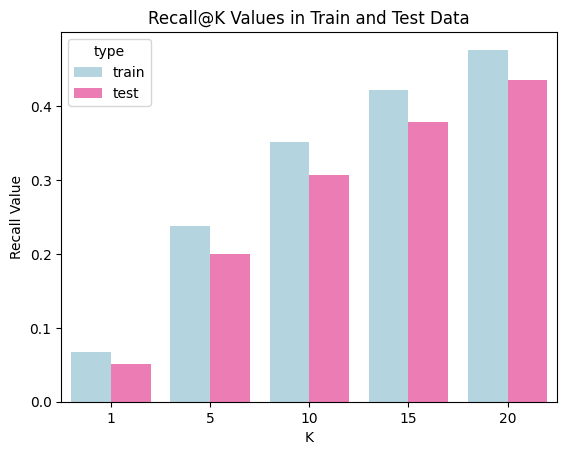

In [22]:
sns.barplot(recalls_dataframe, x="k", y="value", hue="type", palette=["lightblue", "hotpink"])

plt.title("Recall@K Values in Train and Test Data")
plt.xlabel("K")
plt.ylabel("Recall Value")

plt.show()

Here, the results don't look really good. The recall is on the lower side, especially with lower K values. That doesn't look promising.

In [23]:
k_values = [1, 2, 3, 4, 5]
precisions_dataframe = pd.DataFrame(columns=["k", "type", "value"])

for k in tqdm(k_values):
    train_dict = {"k": k, "type": "train", "value": precision_at_k(similarities_train, k)}
    test_dict = {"k": k, "type": "test", "value": precision_at_k(similarities_test, k)}

    precisions_dataframe.loc[len(precisions_dataframe)] = train_dict
    precisions_dataframe.loc[len(precisions_dataframe)] = test_dict

100%|██████████| 5/5 [00:35<00:00,  7.06s/it]


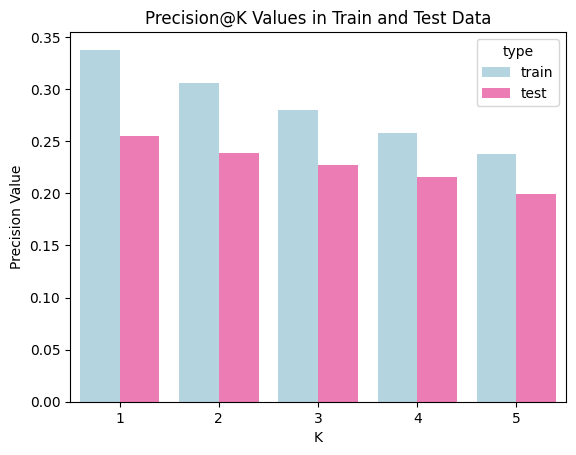

In [24]:
sns.barplot(precisions_dataframe, x="k", y="value", hue="type", palette=["lightblue", "hotpink"])

plt.title("Precision@K Values in Train and Test Data")
plt.xlabel("K")
plt.ylabel("Precision Value")

plt.show()

The precision results are a little bit better-looking. Further manual testing is going to show how well of a job the model is doing.